This notebook calculates subject level ERP responses

In [1]:
import numpy as np  
import matplotlib.pyplot as plt
import json
import os 
import mne

from scipy.io import loadmat

def load_mat_file(file_path):
    mat_contents = loadmat(file_path)
    return mat_contents
    
nsd_mat_file_path = '/srv/eeg_reconstruction/shared/natural_scenes_dataset/nsd_expdesign.mat'
nsd_mat_contents = load_mat_file(nsd_mat_file_path)

shared1000 = nsd_mat_contents['subjectim'][0][0:1000]

file_path = '../final_dataset/data/test_indices.json'
with open(file_path, 'r') as file:
    data_array = json.load(file)

cat_path = '../final_dataset/data/captions_and_categories.json'
with open(cat_path, 'r') as file:
    cat_array = json.load(file)

In [2]:

# Path to the directory containing .fif files
fif_dir = os.path.join('/srv/eeg_reconstruction/shared/biosemi-dataset/final_eeg', '05_125')

# List all .fif files in the directory
fif_files = [f for f in os.listdir(fif_dir) if f.endswith('.fif')]
full_fif_files = [os.path.join(fif_dir, f) for f in fif_files]

# Order the files
full_fif_files.sort()


def average_to_erp(epochs):
    '''
    Function to average epochs over occipital electrodes and return the ERP
    epochs: mne.Epochs

    '''
    # Subset occipital electrodes
    occ_elecs = [ch for ch in epochs.ch_names if ('o' in ch.lower() or 'p' in ch.lower()) and not 'c' in ch.lower()]
    occ_inds = [epochs.ch_names.index(elec) for elec in occ_elecs]

    # Averaging epochs over occipital electrodes
    elec_avg_epochs = mne.channels.combine_channels(epochs, {'occipital': [i for i in occ_inds]}, method = 'mean')
    

    # Average all epochs to get a single ERP
    erp = elec_avg_epochs.average()

    return erp

plt.figure(figsize = (10,5))

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

Not setting metadata
3835 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
3478 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
3607 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
3635 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
3709 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
3662 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
3743 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
3839 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
3837 matching events found


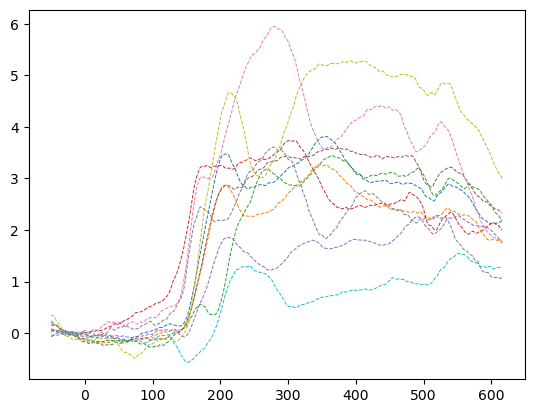

In [4]:

subj_list = []
all_epochs = []
all_erps = []
for i, subj_fif in enumerate(full_fif_files):
    subj_epoch = mne.read_epochs(subj_fif, preload=True, verbose = False)
    subj_list.append(subj_fif.split('/')[-1].split('.')[0].replace('subj', 'Subject ').replace('session', ' Session ').replace('epo', '').replace('_', ' '))
    all_epochs.append(subj_epoch)

    # Average over occipital electrodes
    try:
        erp = average_to_erp(subj_epoch)._data.squeeze() * 1e6
    except:
        continue
    all_erps.append(erp)


    ticks = [i*2 - 50 for i in range(erp.shape[-1])]
    plt.plot(ticks, erp, linestyle = '--', linewidth = 0.7)


# Compute SD for each time point
all_erps = np.array(all_erps)
sd = np.std(all_erps, axis = 0)
gavg_erp = np.mean(all_erps, axis = 0)


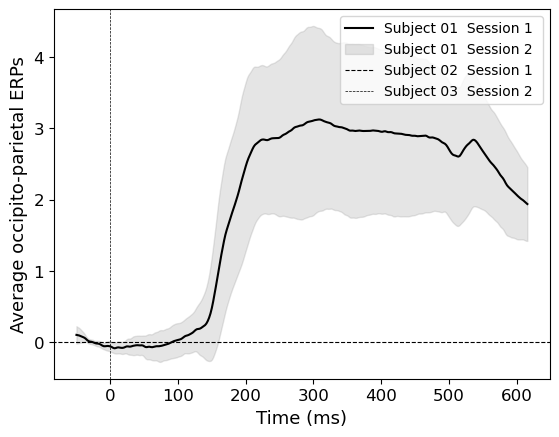

In [5]:

# Grand average added last
#all_epochs = mne.concatenate_epochs(all_epochs)
#gavg_erp = average_to_erp(all_epochs)._data.squeeze()
subj_list.append('Grand Average (SD)')
ticks = [i*2 - 50 for i in range(erp.shape[-1])]
plt.plot(ticks, gavg_erp, linewidth = 1.5, color = 'black')
plt.fill_between(ticks, gavg_erp - sd, gavg_erp + sd, color = 'grey', alpha = 0.2)

# Plot settings
plt.axhline(0, -50, 600, linestyle='--', color = 'black', linewidth = 0.8)
plt.axvline(0, 0, 1, linestyle='--', color = 'black', linewidth = 0.5)
# Add axis labels
plt.tick_params(axis='both', which='major', labelsize=12)  # Increase the font size of the tick labels
title = "Average occipito-parietal ERPs"
plt.ylabel(title, fontsize=13)
plt.xlabel('Time (ms)', size = 13)
plt.legend(subj_list,)
#plt.title(f'{title}', size = 14)
plt.show()